**Оглавление** 

1. [Загрузка данных](#1)
2. [Предобработка данных](#2)
3. [Приоритизация гипотез](#3)
4. [Анализ А/В теста](#4)
5. [Вывод](#5)

# Анализ гипотез и анализ A/B-теста 

**Описание проекта**

Аналитик крупного интернет-магазина вместе с отделом маркетинга подготовили список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Описание данных**

В распоряжении имеется три датасета. Файл hypothesis.csv хранит данные о гипотезах, orders.csv — информацию о заказах, а visitors.csv — информацию о посещениях сайта.

Структура hypothesis.csv:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура orders.csv:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Структура visitors.csv:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

<a id="1"></a> 
### Загрузка данных

Импортируем необходимые библиотеки. Считаем данные из csv-файлов в датафреймы и сохраним их в переменные hypothesis, orders и visitors.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    hypothesis = pd.read_csv('hypothesis.csv')    
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')

**1.1 Обзор исходных данных**

Выведем первые 10 строчек датафрейма hypothesis на экран.

In [3]:
pd.options.display.max_colwidth = 150
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Выведем основную информацию о датафрейме hypothesis с помощью метода info().

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Датафрейм переменной hypothesis содержит 5 столбцов и 9 строк. Из основной информации видно, что датафрейм имеет следующее проблемы:

- названия столбцов содержат заглавные буквы.

Выведем первые 10 строчек датафрейма orders на экран.

In [5]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


Выведем основную информацию о датафрейме orders с помощью метода info().

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Датафрейм переменной orders содержит 5 столбцов и 1197 строк. Из основной информации видно, что датафрейм имеет следующее проблемы:

- столбец 'date' имеeт неверный типы данных.

Выведем первые 10 строчек датафрейма visitors на экран.

In [7]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Выведем основную информацию о датафрейме visitors с помощью метода info().

In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Датафрейм переменной visitors содержит 3 столбца и 62 строки. Из основной информации видно, что датафрейм имеет следующее проблемы:

- столбец 'date' имеeт неверный типы данных.

<a id="2"></a> 
### Переработка данных

**2.1 Работа с названиями столбцов**

Все столбцы датафрейма hypothesis имеют в названии заглавные буквы, что неудобно для дальнейшей работы. Переименуем их и приведем названия к единому стилю заменив заглавные буквы на строчные .

In [9]:
hypothesis.columns = hypothesis.columns.str.lower()

**2.2 Работа с типом данных**

Столбцы 'date' датафреймов orders и visitors имеют тип данных object несмотря на то, что указанные столбцы содержат информацию о датах. Для возможности работы с ними в дальнейшем изменим тип данных на datetime.

In [10]:
orders['date'] = pd.to_datetime(orders['date'])

In [11]:
visitors['date'] = pd.to_datetime(visitors['date'])

**2.3 Обработка дубликатов**

Проверим наличие дубликатов в датафреймах.

In [12]:
# вывод количества дубликатов
print('Количество дубликатов в датафрейме visits:', hypothesis.duplicated().sum())
print('Количество дубликатов в датафрейме orders:', orders.duplicated().sum())
print('Количество дубликатов в датафрейме costs:', visitors.duplicated().sum())

Количество дубликатов в датафрейме visits: 0
Количество дубликатов в датафрейме orders: 0
Количество дубликатов в датафрейме costs: 0


**2.4 Обработка пропусков**

Проверим наличие пропусков в датафреймах.

In [13]:
print('======hypothesis======')
print(hypothesis.isna().sum())
print('======orders======')
print(orders.isna().sum())
print('======visitors======')
print(visitors.isna().sum())

======hypothesis======
hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64
======orders======
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
======visitors======
date        0
group       0
visitors    0
dtype: int64


Пропуски в данных во всех датафреймах отсутствуют.

Выведем основную информацию о датафрейме с помощью метода info(), чтобы удостовериться, что данные готовы для анализа.

In [14]:
print('======hypothesis======')
hypothesis.info()
print('======orders======')
orders.info()
print('======visitors======')
visitors.info()

======hypothesis======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
======orders======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage:

Вся необходимая переработка данных проведена.

<a id="3"></a> 
### Приоритизация гипотез

Выведем данные о гипотезах на экран.

In [15]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Поскольку проверка гипотез чаще всего стоит дорого, а ресурсов не всегда хватает, необходимо определить какая гипотеза будет тестироваться, а какая нет. Чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, сформулированные гипотезы приоритизируют.

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [16]:
# расчет ICE для гипотез на основании их параметров
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
# вывод столбцов 'hypothesis' и 'ICE', отсортированных по столбцу 'ICE'
hypothesis[['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending = False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по ICE - гипотезы с индексами 8, 0, 7.

Далее применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [17]:
# расчет RICE для гипотез на основании их параметров
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
# вывод столбцов 'hypothesis' и 'RICE', отсортированных по столбцу 'ICE'
hypothesis[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по RICE - гипотезы с индексами 7, 2, 0 и 6. Таким образом у нас произошла смена лидера по сравнению с ICE.

Так получилось потому, что параметр reach у гипотезы с индексом 7 выше, чем у остальных. Параметр Reach показывает скольких пользователей затронет изменение, которое мы хотим внести. Таким образом кроме силы гипотез необходимо учитывать как много пользователей он затронет.

<a id="4"></a> 
### Анализ А/В теста

Изучим графики кумулятивных (накапливаемых) данных. 

Перед началом теста определим количество групп и количество участников в них.

In [18]:
# сгруппируем данные по группам и найдем количество уникальных пользователей 
# в каждой из нах 
orders.groupby('group').agg({'visitorId':'nunique'})

,visitorId
group,
A,503
B,586


Пользователи были разделены на 2 группы, численностью 503 чел. (в группе А) и 586 чел. (в группе В). Разница в количестве участников в группах составляет 83 чел., или 16,5%. Это говорит о том, что к результатам теста нужно относиться с осторожностью.

Количество групп свидетельствует о том, что тест был парный.

Далее определим сроки проведения теста.

In [19]:
print('Начало теста:', orders['date'].min())
print('Конец теста:', orders['date'].max())

Начало теста: 2019-08-01 00:00:00
Конец теста: 2019-08-31 00:00:00


Продолжительность теста составила 1 месяц с 01 августа 2019 до 31 августа 2019.

Очень важно также проверить, нет ли в данных пользователей, участвовавших в нескольких группах теста одновременно. Большое количество таких пользователей приведет к искажению результатов теста.

In [20]:
# сгруппируем данные по пользователям и найдем тех из них,
# кто был более чем в одной группе
orders.groupby('visitorId').agg({'group':'nunique'}).value_counts()

group
1        973
2         58
dtype: int64

Чуть больше 5% пользователей участвовали в нескольких группах теста одновременно. В связи с небольшим количеством продолжим анализ данных с учётом таких пользователей.

Рассчитаем кумулятивные данные о заказах и посетителях интернет-магазина.

In [21]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

#получим агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])
    ].agg({'date': 'max', 'group': 'max', 'transactionId': 'nunique', 'visitorId': 'nunique', 'revenue': 'sum'}),
    axis=1).sort_values(by=['date', 'group'])

#получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

**4.1. Построим график кумулятивной выручки по группам.**

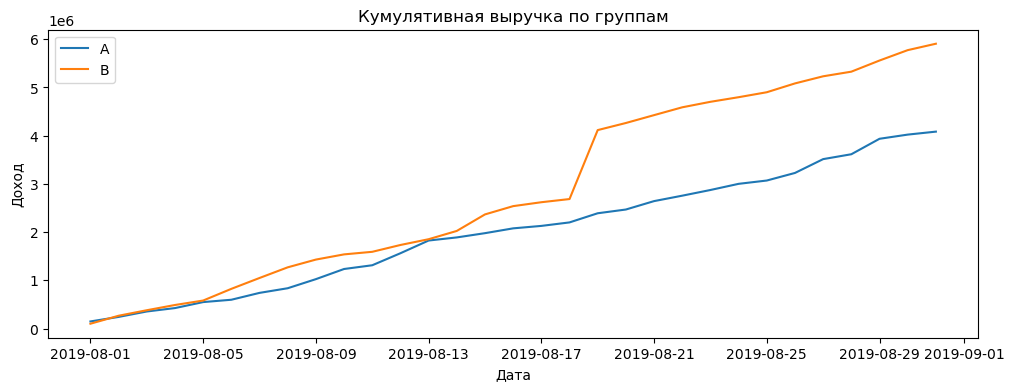

In [22]:
plt.figure(figsize=(12,4))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Доход')
plt.legend();

Выручка почти равномерно увеличивается в течение всего теста. В середине теста сегмент В вышел вперед и продолжил лидировать до конца теста. Однако график выручки группы В в одной точке резко растет. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Необходимо выяснить причину данного всплеска. При заключительном анализе аномально большие заказы необходимо будет удалить.

**4.2. Построим график кумулятивного среднего чека по группам.**

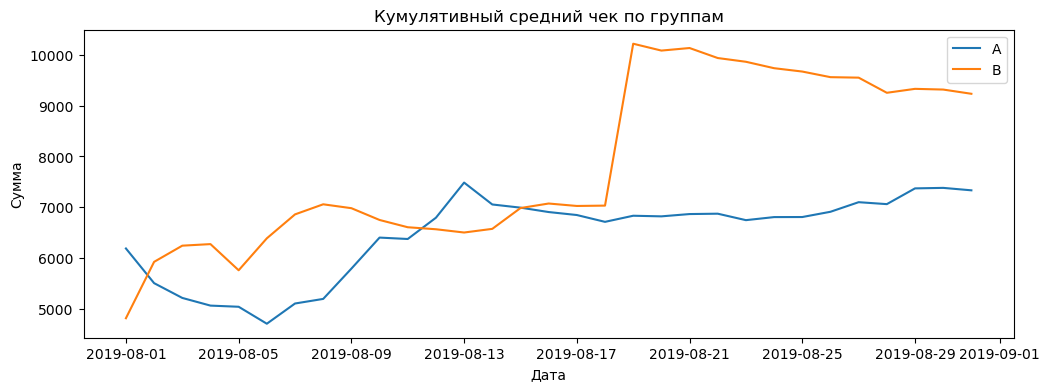

In [23]:
plt.figure(figsize=(12,4))

# делаем расчет и строим график размера среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')

# делаем расчет и строим график размера среднего чека группы В
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.legend();

Средний чек тоже становится равномерным ближе к концу теста: для группы A он изменяется незначительно, а для группы В наблюдается его снижение. Однако и здесь виден резкий всплеск по группе В во второй половине теста. Возможно, в группу B попали крупные заказы. Необходимо получить больше данных, чтобы прийти к реальному среднему чеку.

**4.3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A.**

In [24]:
# объединяем кумулятивные данные в разрезе групп в одной таблице
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

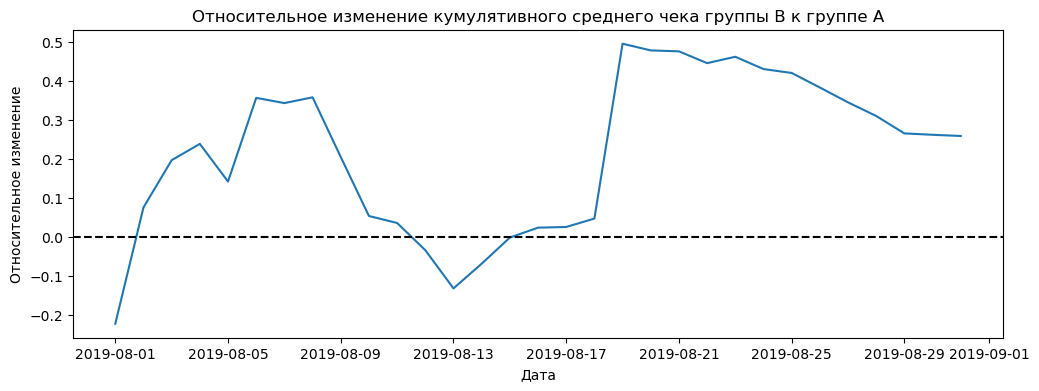

In [25]:
plt.figure(figsize=(12,4))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение');

Результаты теста значительно и резко менялись в несколько дат. Видимо, именно тогда были совершены аномальные заказы.

**4.4. Построим график кумулятивного среднего количества заказов на посетителя по группам.**

Рассчитаем среднее количество заказов на посетителя по каждой группе.

In [26]:
# считаем кумулятивное среднее количества заказов на пользователя
cumulativeData['avg'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

Теперь можно построить график.

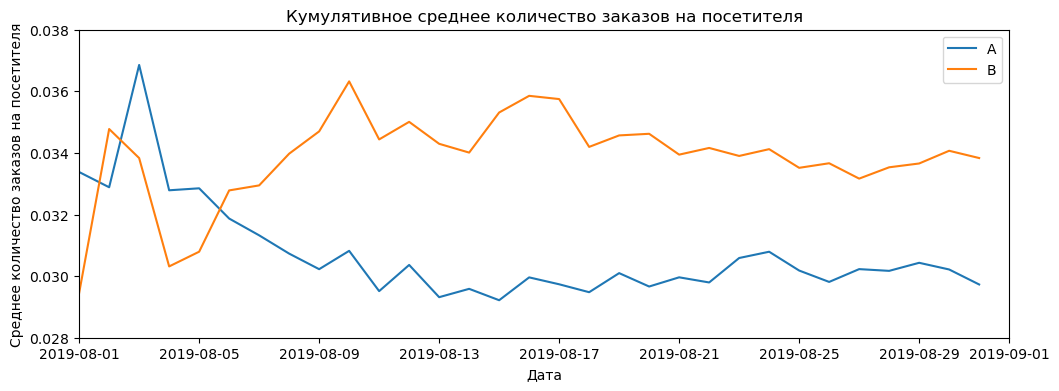

In [27]:
# строим графики
plt.figure(figsize=(12,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['avg'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['avg'], label='B')

plt.title('Кумулятивное среднее количество заказов на посетителя')
plt.xlabel('Дата')
plt.ylabel('Cреднее количество заказов на посетителя')
plt.legend()
# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.028, 0.038]);

Кумулятивное среднее количество заказов на посетителя группы В в первой половине теста вырвалось вперёд и зафиксировалось. Данный показатель по группе А просел и также зафиксировался.

**4.5. Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.**

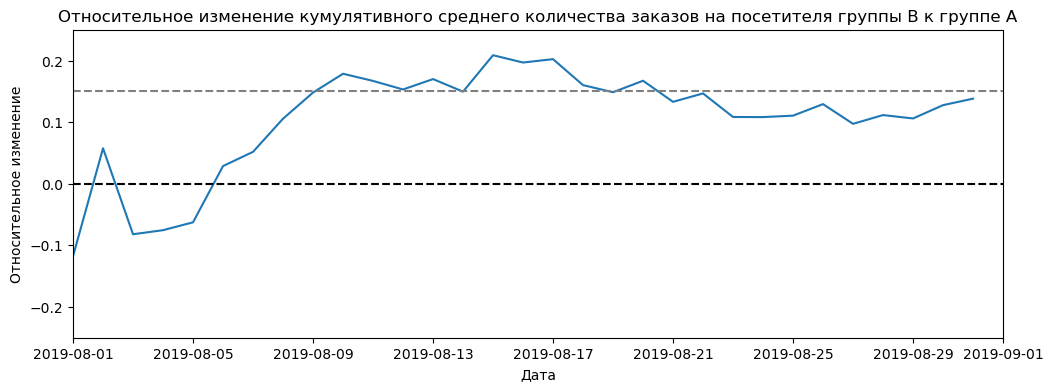

In [28]:
# объединим таблицы с данными
mergedCumulativeConversions = cumulativeDataA[['date','avg']].merge(
    cumulativeDataB[['date','avg']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,4))
# строим графики
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['avgB']/mergedCumulativeConversions['avgA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.25, 0.25]);

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд и зафиксоровалась на уровне прироста примерно 14%.

**4.6. Построим точечный график количества заказов по пользователям.**

Сначала подготовим данные.

In [29]:
# сформируем таблицу, в которой будут рассчитано количество заказов для каждого пользователя
ordersByUsers = (orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'}))
ordersByUsers.columns = ['userId', 'orders']

Теперь построим график.

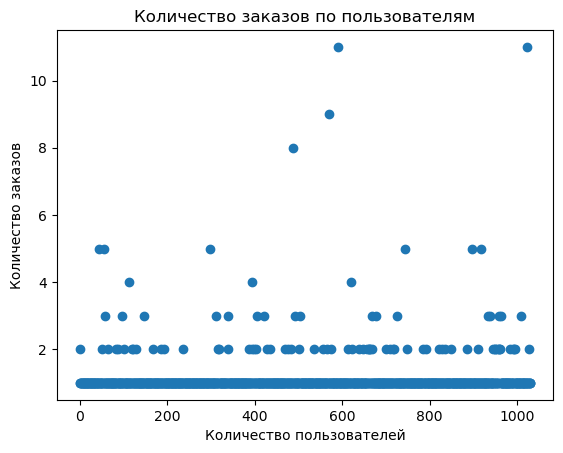

In [30]:
x_values = pd.Series(range(0,len(ordersByUsers)))
# построим график
plt.scatter(x_values, ordersByUsers['orders'])

plt.title('Количество заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов');

Большинство покупателей заказывали только один раз. Тех, кто сделал 2 заказа значительно меньше, а более 2-х - вообще незначительное количество. Однако точная доля пользователей с большим количеством заказов не ясна — непонятно, считать их аномалиями или нет.

**4.7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Установим границу для определения аномальных пользователей.**

In [31]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей оформляли более 2х заказов. И только 1% пользователей заказывали более 4х раз.

Примем за аномальных пользователей тех, кто совершил более 2 заказов. Так мы уберём 5% пользователей с наибольшим числом заказов.

**4.8. Построим точечный график стоимостей заказов.**

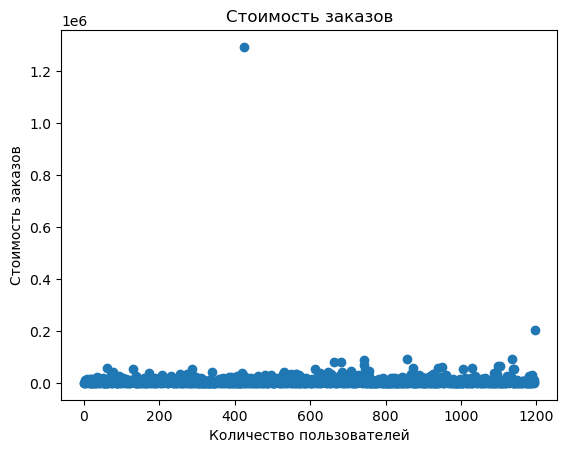

In [32]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(orders['revenue'])))
# построим график
plt.scatter(x_values, orders['revenue'])

plt.title('Стоимость заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов');

На графике видно, что были очень дорогие заказы, но из было мало. Построим аналогичный  график без учета таких заказов.

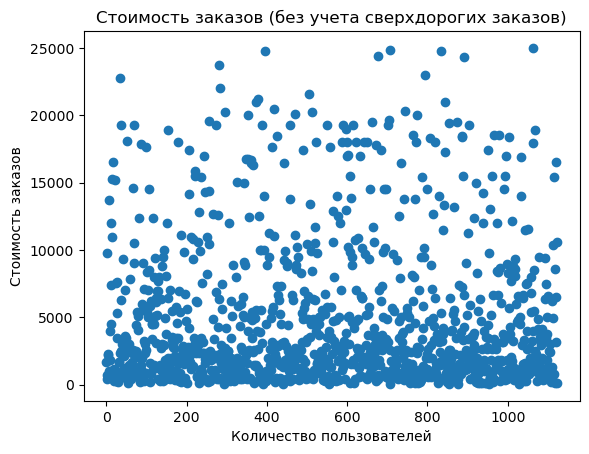

In [33]:
# сделаем срез данных, удалив заказы, стоистью более 25 000 руб.
orders_for_plot = orders.query('revenue < 25000')
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(orders_for_plot['revenue'])))
# построим график
plt.scatter(x_values, orders_for_plot['revenue'])

plt.title('Стоимость заказов (без учета сверхдорогих заказов)')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов');

Стоимость основной части заказов находилась в пределах 5 000 руб. 

Далее необходимо определить долю дорогих заказов.

**4.9. Посчитаем 95-й и 99-й перцентили стоимости заказов. Установим границу для определения аномальных заказов.**

In [34]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% заказов были со стоимостью более 28 000 рублей, и не более 1% дороже 58 233 рублей.

Примем за аномальные заказы те, стоимость которых составила больше 28 000 рублей. Так мы уберём 5% заказов с наибольшей стоимостью.

**4.10. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами между группами по «сырым» данным.**

Для рассчета статистической значимости различия среднего количества заказов по результатам теста применим тест Манна-Уитни. Данный тест будет применен в связи с тем, что в данных есть большие (по сравнению с нормальным распределением) выбросы. В такой ситуации алгебраические метрики работают плохо и предпочтительнее использовать параметрические.

Сформулируем гипотезу. Нулевая: различий в среднем количестве заказов на посетителя между группами нет. Альтернативная: различия в среднем  количестве заказов на посетителя между группами есть.

Для анализа здесь и далее будем использовать уровень статистической значимости в размере 5%.

Для начала подготовим общие данные.

In [35]:
data = visitors.pivot_table(index = 'date', columns = 'group', values = 'visitors')
data.columns = ['visitorsPerDateA', 'visitorsPerDateB']

Подготовим данные для расчета статистической значимости различий в среднем количестве заказов на посетителя между группами между группами по «сырым» данным.

In [36]:
# создадим таблицу с общим количеством заказов по каждому пользователю по группе А и присваиваем ее столбцам понятные названия
ordersByUsersA = (orders[orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique}))
ordersByUsersA.columns = ['userId', 'orders']

# создадим таблицу с общим количеством заказов по каждому пользователю по группе В и присваиваем ее столбцам понятные названия
ordersByUsersB = (orders[orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique}))
ordersByUsersB.columns = ['userId', 'orders'] 

# по группам А и В создадим таблицы, в которых будут указаны пользователи и общее количество их заказов. 
# тем, кто ничего не заказал, будут соответствовать нули
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series
                     (0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series
                     (0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Произведем расчет p-value и относительного различия между группами.

In [37]:
# произведем расчет p-value
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# произведем расчет  относительного различия между группами
print('Относительное изменение среднего В к среднему А:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.017
Относительное изменение среднего В к среднему А: 0.138


Р-value значительно меньше 0.05, поэтому нулевую гипотезу отвергаем. Анализ "сырых" данных показывает, что в среднем количестве заказов на посетителя между группами есть статистически значимые различия. Относительный прирост среднего группы B к среднему группы А равен 13.8%.

**4.11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным**

Сформулируем гипотезу. Нулевая: различий в среднем чеке заказов между группами нет. Альтернативная: различия в среднем  чеке заказов между группами есть.

In [38]:
# произведем расчет p-value
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu
                                   (orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
# произведем расчет  относительного различия между группами
print('Относительное изменение среднего В к среднему А:', 
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.729
Относительное изменение среднего В к среднему А: 0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A - почти на 26%.

Далее необходимо провести анализ без аномалий.

**4.12. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами между группами по «очищенным» данным.**

Уберем из анализируемых данных 

In [39]:
# cделаем срезы пользователей с более чем двумя заказами
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId'], 
                                 ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId']], axis=0)

# cделаем срезы заказов стоимостью более 28 000 рублей
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitorId']

# объединим два среза создав перечень уникальных комбинаций пользователей с большим количеством заказов 
# и пользователей с аномально дорогими заказами
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values())

Пределим количество исключаемых покупателей.

In [40]:
print('Количество исключаемых покупателей:', abnormalUsers.count())
print('Доля исключаемых покупателей, %:', (abnormalUsers.count() / len(orders['visitorId'].unique()) * 100).round(2))

Количество исключаемых покупателей: 74
Доля исключаемых покупателей, %: 7.18


В тесте учавствовало 74 пользователя с большим количеством заказов и/или пользователей с аномально дорогими заказами. Таким образом мы исключили примерно 7.2% покупателей.

In [41]:
# по группам А и В создадим таблицы, в которых будут указаны пользователи и общее количество их заказов. 
# исключим из них пользователей и большим количеством заказов и пользователей с аномально дорогими заказами
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0) 

Произведем расчет p-value и относительного различия между группами по «очищенным» данным.

In [42]:
# произведем расчет p-value
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
# произведем расчет  относительного различия между группами
print('Относительное изменение среднего В к среднему А:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.013
Относительное изменение среднего В к среднему А: 0.173


P-value практически не изменился, но и разница по среднему количеству заказов на посетителя между сегментами увеличилась с 13,8% до 17,3%.

**4.13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

In [43]:
# произведем расчет p-value
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', np.logical_not(
    orders['visitorId'].isin(abnormalUsers)))]['revenue'], orders[np.logical_and(orders['group'] == 'B', np.logical_not(
    orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))
# произведем расчет  относительного различия между группами
print('Относительное изменение среднего В к среднему А:', "{0:.3f}".format(orders[np.logical_and(orders['group'] == 'B', np.logical_not(
    orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A', np.logical_not(
    orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

p-value: 0.738
Относительное изменение среднего В к среднему А: -0.020


P-value практически не изменился, но и разница между сегментами сократилась с 26% до -2%.

<a id="5"></a> 
### Вывод

Результаты проведенного A/B-теста показывают:

- Есть статистически значимое различие в среднем количестве заказов на посетителя  между группами как по «сырым» данным, так и после фильтрации аномалий.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.
- График различия среднего чека колеблется. Именно он позволил найти аномалии. Сделать из этого графика определённые выводы нельзя.

Исходя из обнаруженных фактов, тест следует остановить и зафиксировать победу группы В.